## In this R notebook I use Millar et al's workflow for automatic event delineation using the s::can and discharge data from [Kincaid et al., 2020](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027361). In [this notebook](https://github.com/MeganEDuffy/cQ_analysis/blob/main/md-notebooks/Kincaid2020_Millar_workflow.ipynb) I follow through with event hysteresis index and flushing index determination, but here I am just adjusting the Millar code to get event water yields and nutrient yields for this dataset.

- ### Data publicly available here on HydroShare: https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/

- ### This larger dataset includes the 2014-2015 discharge and nitrate data from Vaughan, M. (2017). Vermont NEWRnet stations: 2014-2015 high-frequency DOC, nitrate, and discharge data, HydroShare, http://www.hydroshare.org/resource/faac1672244c407e9c9c8644c8211fd6.

- ### Note that there is a Hungerford data gap in 2016 to adjust this code for

- ### I downloaded on 05.02.24 and put it here in this directory /home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_partition_hysteresis

- ### The raw data file has discharge (q m3s), NO3, and SRP with timestamp and event start/end times for each watershed. The Millar code takes just timestamp, q, and C input csvs so I separate this raw data file into just those parameters for each site over the entire time period (>400 events from 2014 to 2018, no winter events).

## Kincaid 2020 RDF (HydRun) parameters, prior to manual manipulation

- Taken from the SI (Table S3)


|            | catchment area (km2) | Kincaid 2020 HydRun SFT (cms) | Kincaid 2020 HydRun baseflow separation FC | Kincaid 2020 return ratio (0-1) | Kincaid 2020 minimum event duration (hr) |
|------------|----------------------|-------------------------------|--------------------------------------------|---------------------------------|------------------------------------------|
| Hungerford | 48.1                 |  			0.10 		                        |  			0.996 		                                    |  			0.18 		                          | 6                                        |
| Wade       | 16.7                 |  			0.05 		                        |  			0.996 		                                    |  			0.18 		                          | 4                                        |
| Potash     | 18.4                 |  			0.12 		                        |  			0.996 		                                    |  			0.20 		                          | 4                                        |

### TO DO

- [x] change 'Hford' df name to something non site-specific
- [x] loop through all water years and combine into single storm event df
- [x] add in NO3 yields
- [x] fix file naming (get rid of spaces)
- [ ] add site name column to stormEventCalcs function for csv save out purposes
- [ ] find and plot Kincaid event ranges and yields
- [ ] interactive viewer?

In [59]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)

###################
# SET DIRECTORIES #
###################

# Define the input and output directories

# For Kincaid data, input and output in separate directory
input_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare/"
output_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/kincaid2020_hydroshare/output/"

# functions script in main millar directory
millar_input_dir <- "/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/"

#####################
# READ IN FUNCTIONS #
#####################

# 2024-07-08 MED note: I made a new version of the Millar functions script with my modifications
source(file.path(input_dir,"cQ_functions_MED.R"))

#################
# SET SITE INFO #
#################

# Set site name
Site = "Hungerford"

# Set year if doing yearly
#Year = 2015

# Set constituent
Analyte = "NO3"

# Set catchment area
Area = 48.1 #Hungerford

################
# READ IN DATA #
################

# Read in raw Hydroshare data csv from Kincaid et al 2020 found at https://www.hydroshare.org/resource/85fa32a11fbb49779033934a135f54ef/
# Downloaded on 05.02.24

allInputData15Min <- read.csv(file.path(input_dir,"hydroshare_rawData.csv"))

# Rename the 'timestamp' column to 'datetime' to conform with Millar script
names(allInputData15Min)[names(allInputData15Min) == "timestamp"] <- "datetime"

# Filter the data for just the site and for the year/time range you want
# Memory issues if you try to process all the Kincaid 2014-2018 data at once
# Remove rows with missing values
Site_input <- allInputData15Min %>%
  #filter(site == Site & year(datetime) == Year) %>%
  filter(site == Site) %>%
  drop_na(q_cms, NO3_mgNL) %>%
  select(datetime, q_cms, conc = NO3_mgNL)

# Specify constituent in data set name
dataSetName = paste(Site,"_",Analyte,"_","2014-2018", sep="")

# Chose constitution for plot axes labels (NO3, TOC, or turbidity)
constit <- Analyte

Site_input$datetime <- as.POSIXct(Site_input$datetime,format("%Y-%m-%d %H:%M:%S"),tz="EST")

# Rescale the data
Site_input <- Site_input %>% 
  mutate(rescaled_conc = ((conc-min(conc))/(max(conc)-min(conc))*max(q_cms)))

### Running Millar batch event delineation with Kincaid parameters

- 2024-07-08 MED note: I went into cQ_functions_MED.R and changed the `stormEventCalcs` function so that a column called `tot_constit_mgNL` is created, a nitrate/DOC/any constituent analog of the `tot_q_m3` that is calculated in the original Millar script.

In [60]:
###################
# SET RDF PARAMS #
##################

# Vector containing candidate baseflow separation filter values
candidateFilterPara <- c(0.996,0.98) # Kincaid 2020 used 0.996 for all catchments

# Vector containing candidate stormflow threshold values
candidateSfThresh <- c(0.098,0.1,0.12) #Kincaid 2020 used 0.1 for Hungerford

# Vector with interpolation intervals used for calculating HI
interp <- seq(0,1,0.01)

###############################
# RUN ANALYSIS TO GET EVENTS #
###############################

batchRun1 <- batchRunBfAndEvSepForCQ(qInputs = Site_input,
                                     bfSepPasses = 3, # orig 3
                                     filterParam = candidateFilterPara,
                                     sfSmoothPasses = 4, # orig 4
                                     sfThresh = candidateSfThresh,
                                     cInputs = Site_input,
                                     timeStep = 15,
                                     minDuration = 4, # Kincaid 2020 uses 4 hrs for Hungerford
                                     maxDuration = 200)

eventsDataAll1 <- getAllStormEvents(batchRun = batchRun1,
                                    timestep_min = 15)

batchRunFlowsLF1 <- batchRunflowCompare(qData = Site_input,
                                         bfSepPasses = 4, # orig 4
                                         filterPara = candidateFilterPara,
                                         sfSmoothPasses = 4) # orig 4

eventsData1 <- stormEventCalcs(batchRun = batchRun1,
                               timestep_min = 15)

eventsData1$start <- as.Date(eventsData1$start) # Assuming Datetime is in POSIXct format
eventsData1$filter_para <- as.numeric(eventsData1$filter_para)

# Add water yield column (in mm) using catchment area
eventsData1 <- eventsData1 %>%
  mutate(
    water_yield_mm = tot_q_m3 / (Area * 10^6) * 1000,
  )

# Add constituent yield column (in mm) using catchment area
eventsData1 <- eventsData1 %>%
  mutate(
    constit_yield_mm = (tot_constit_mgN) / (Area * 10^6),
  )

stormCounts1 <- stormCounts(batchRun1)

# Not dealing with HI calc in this workflow
#hysteresisData1 <- getHysteresisIndices(batchRun = batchRun1,
                                        #xForInterp = interp,
                                        #eventsData = eventsData1)


### Export the results

### change from Millar: calculate water yield and save in the file called "_StormEventSummaryData.csv"

In [61]:
######################
# EXPORT OUTPUT DATA #
######################

write.csv(eventsData1,file = file.path(output_dir,paste(dataSetName,"_StormEventSummaryData.csv",sep="")))
write.csv(batchRunFlowsLF1,file = file.path(output_dir,paste(dataSetName,"_DischargeData.csv",sep="")))
#write.csv(hysteresisData1,file = file.path(output_dir,paste(dataSetName,"_HysteresisData.csv",sep="")))
write.csv(eventsDataAll1,file = file.path(output_dir,paste(dataSetName,"_AllCQData.csv",sep="")))
write.csv(stormCounts1,file = file.path(output_dir,paste(dataSetName,"_StormCounts.csv",sep="")))

### Plot and save event delineation data

In [154]:
#########################################
# PLOT AND SAVE DATA - EVENT SEPARATION #
#########################################

# Make subfolder in output directory to save hydrograph plots
dir.create(file.path(output_dir, "Hydrographs"), showWarnings = FALSE)

# 1) Plot and save the hydrograph with input data
# MED note that for the Kincaid data I had to change 'timestamp' to 'datetime'when reading in the csv

initialHydrograph <- ggplot(Site_input,aes(x=datetime, y=q_cms)) +
                            geom_line(size=0.5, color="black") +
                            xlab(NULL) +
                            ylab(expression(paste("Total discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_TotalDischarge.jpeg")),
       initialHydrograph,
       width = 12, 
       height = 4, 
       units = "in",
       dpi=600)


# 2) Plot total discharge with baseflow

baseflowHydrograph <- ggplot() + 
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=total_flow), size=0.5, color="black") +
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=base_flow,color=filter_para), size=0.75) +
                            scale_color_brewer(palette = "Set1") +
                            xlab(NULL) +
                            ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(legend.title = element_blank(),
                                  text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_Baseflows.jpeg")),
       baseflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3) Plot smoothed storm flows

stormflowHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), size=0.75) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnly.jpeg")),
       stormflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3a) Plot smoothed storm flows with storm flow thresholds

stormflowThreshHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), size=0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = candidateSfThresh, linetype = "dashed", color = "black",alpha=0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnlyWithThresholds.jpeg")),
       stormflowThreshHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 4) Plot batch run event separation hydrographs
eventsDataShaded1 <- eventsData1 %>% mutate(start = as.POSIXct(start,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            end = as.POSIXct(end,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            tops = max(Site_input$q_cms),
                                            bottoms = 0)

batchEventSepPlot <- ggplot() + 
  geom_rect(data=eventsDataShaded1, mapping=aes(xmin=start, 
                                                xmax=end, 
                                                ymin=bottoms, 
                                                ymax=tops), fill="green", color="red", alpha=0.2) +
  
  geom_line(data=Site_input, aes(x=datetime, y=q_cms), size=0.8, color="blue") +
  geom_line(data=Site_input, aes(x=datetime, y=rescaled_conc), size=0.5, color="black",linetype="dashed") +
  facet_wrap(~ run_id, ncol = 1) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))


ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_BatchEventSeparationPlot.jpeg")),
       batchEventSepPlot,
       width = 8, 
       height = 10, 
       units = "in",
       dpi=600)

# Just viewing the yearly hydrograph here
#initialHydrograph

Warning message:
“Removed 4 rows containing missing values (`geom_rect()`).”


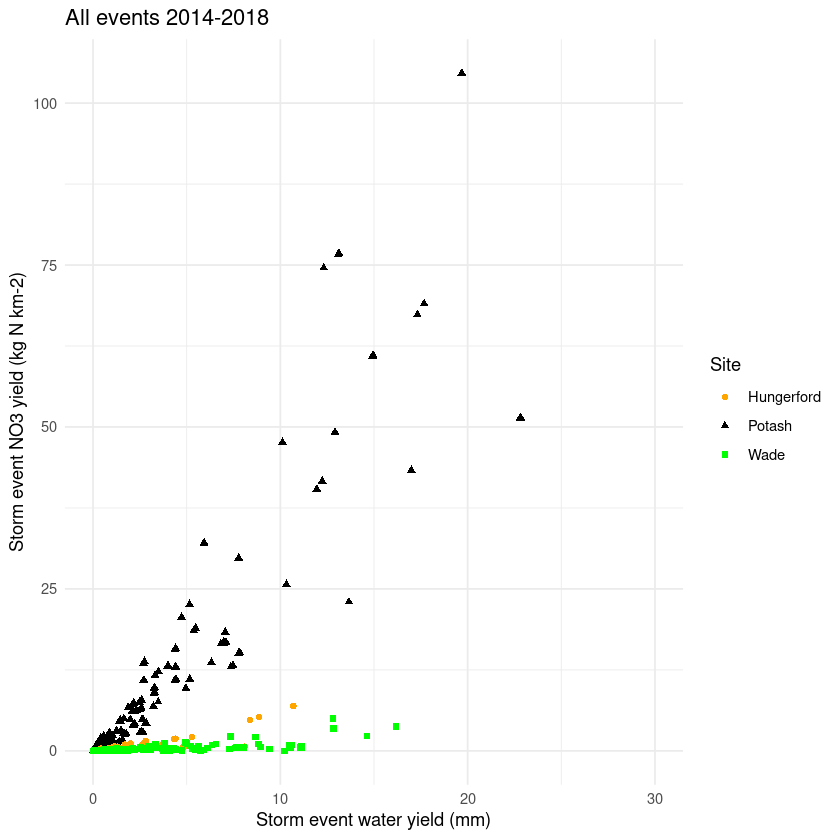

In [83]:
# Import the yield data from output csvs and put in a list

summary_files <- list.files(file.path(output_dir), pattern = "\\StormEventSummaryData.csv$", full.names = TRUE)

summary_data = lapply(summary_files, read.csv)

# Combine the data frames into a single data frame
sites <- c("Potash", "Hungerford", "Wade")
summary_data_combined <- do.call(rbind, lapply(1:length(summary_data), function(i) {
  df <- summary_data[[i]]
  df$Site <- sites[i]
  return(df)
}))

# Filter the data for just FC = 0.996
filtered_data <- subset(summary_data_combined, filter_para == 0.996)

# Create the plot
storm_yields_plot <- ggplot(filtered_data, aes(y = constit_yield_mm, x = water_yield_mm, shape = Site)) +
  geom_point(aes(color = Site)) +
  scale_color_manual(values = c("Potash" = "black", "Hungerford" = "orange", "Wade" = "green")) +
  labs(title = "All events 2014-2018", 
       x = "Storm event water yield (mm)",
       y = "Storm event NO3 yield (kg N km-2)") +
  xlim(0, 30) +
  theme_minimal()

# Display the plot
print(storm_yields_plot)